<a href="https://colab.research.google.com/github/Ry02024/SignateCup2024Summer_Ry032/blob/master/notebooks/02_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習のPDCA：予測モデルの生成

ここではLightGBMモデルを構築し、予測を行います。まず、データを結合して前処理を行い、質的データにラベルエンコーディングを適用します。次に、トレーニングデータを訓練用と検証用に分割し、モデルを訓練。AUCスコアとROC曲線でモデルの性能を評価します。最後に、テストデータで予測を実行し、その結果を提出用ファイルとして保存します。これにより、一連の機械学習プロセスを効率的に完結させます。

## ライブラリの読み込み

本プロジェクトでは、データの前処理、機械学習モデルの作成、モデルの評価を行うために、必要なライブラリをインポートします。numpy や pandas などの基本的なデータ操作ライブラリに加え、LightGBM などの機械学習ライブラリや、モデル評価のためのメトリクスライブラリを使用しています。

In [ ]:
# 必要なパッケージのインストール
!pip install japanize-matplotlib -q
!pip install catboost -q
!pip install category_encoders -q

# GitHubリポジトリのクローン
!git clone https://github.com/Ry02024/SignateCup2024Summer_Ry032.git

# 必要なライブラリのインポート
import japanize_matplotlib
import pandas as pd
import numpy as np
import re
import unicodedata
import datetime as dt
import matplotlib.pyplot as plt

# モデル関連ライブラリのインポート
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, roc_auc_score, roc_curvefrom, precision_recall_curve, average_precision_score

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# カテゴリカルエンコーディングのためのライブラリ
from category_encoders import CatBoostEncoder

# クローンしたリポジトリ内のスクリプトをインポート
from SignateCup2024Summer_Ry032.src import preprocessing
from SignateCup2024Summer_Ry032.src import visualization
from SignateCup2024Summer_Ry032.src import model_optimization
from SignateCup2024Summer_Ry032.src.evaluate_model import auc_eval, pr_auc_eval, focal_loss_lgb, weighted_cross_entropy, dice_loss, asymmetric_loss, balanced_cross_entropy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00
Cloning into 'SignateCup2024Summer_Ry032'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 170 (delta 77), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (170/170), 2.47 MiB | 7.94 MiB/s, done.
Resolving deltas: 100% (77/77), done.


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## データの読み込み

トレーニングデータとテストデータをGoogle Driveから読み込み、pandas データフレームとして保持します。トレーニングデータでは、学習に不要なカラム（id と ProdTaken）を削除し、特徴量とターゲットに分けます。テストデータでは、id カラムを削除して特徴量を取り出します。

In [ ]:
%cd SignateCup2024Summer_Ry032/

/content/SignateCup2024Summer_Ry032


In [ ]:
data_dir = "data/processed/basic/"
train_processed = pd.read_csv(data_dir + "train_processed.csv")
test_processed = pd.read_csv(data_dir + "test_processed.csv")

In [ ]:
train_processed_x = train_processed.drop(['ProdTaken'], axis=1)
train_processed_y = train_processed['ProdTaken']

## モデルの生成

前処理が完了したデータを使用して、LightGBM モデルを作成します。まず、トレーニングデータをさらに訓練用と検証用に分割し、モデルの動作確認を行います。この段階では、クロスバリデーションやK-Foldは使用せず、単純にデータを分割してモデルを訓練します。モデルの性能を評価するために、検証データを使用してAUCスコアを算出し、ROC曲線をプロットしています。

### 前処理

In [ ]:
# データフレーム内のカテゴリカルカラムを推定
categorical_columns = train_processed_x.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# ラベルエンコーディングの適用
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    train_processed_x[col] = le.fit_transform(train_processed_x[col].astype(str))
    test_processed[col] = le.transform(test_processed[col].astype(str))
    label_encoders[col] = le  # 将来的に必要な場合に備えてエンコーダーを保存

In [ ]:
# トレーニングデータと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(train_processed_x, train_processed_y, test_size=0.2, random_state=42)

In [ ]:
# LightGBM データセットを作成
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_columns)

### binary_logloss, auc, prauc

In [ ]:
# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=100),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=500, verbose=True)
]
# モデルのパラメータ設定
params = {
    'objective': 'binary',
    'metric': 'none',  #['binary_logloss', 'auc'],  # AUCを計算するために'metric'に'auc'を追加
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'random_state': 42,
    'force_row_wise': True,  # オーバーヘッドを削減
    'scale_pos_weight':len(y_train) / (2 * np.sum(y_train)),  # 正例に対する負例を調整
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=10000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks=callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)

# AUCスコアの計算
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)

# PR-AUCスコアの計算
pr_auc_score = average_precision_score(y_valid, y_valid_pred_probs)

# 結果の表示
print(f"AUCスコア: {auc_score:.4f}")
print(f"PR-AUCスコア: {pr_auc_score:.4f}")


[LightGBM] [Info] Number of positive: 406, number of negative: 2385
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145468 -> initscore=-1.770601
[LightGBM] [Info] Start training from score -1.770601
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.929095	training's pr_auc: 0.69115	valid_1's auc: 0.849566	valid_1's pr_auc: 0.536965
[200]	training's auc: 0.952309	training's pr_auc: 0.758324	valid_1's auc: 0.852164	valid_1's pr_auc: 0.530576
[300]	training's auc: 0.968382	training's pr_auc: 0.819605	valid_1's auc: 0.857288	valid_1's pr_auc: 0.538998
[400]	training's auc: 0.979423	training's pr_auc: 0.874938	valid_1's auc: 0.857288	valid_1's pr_auc: 0.534672
[500]	training's auc: 0.987205	training's pr_auc: 0.916268	valid_1's auc: 0.857324	valid_1's pr_auc: 0.538903
[600]	training's auc: 0.991605	training's pr_auc: 0.942926	val

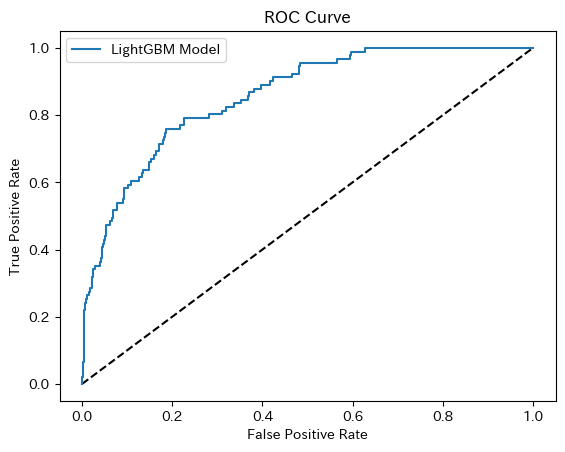

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

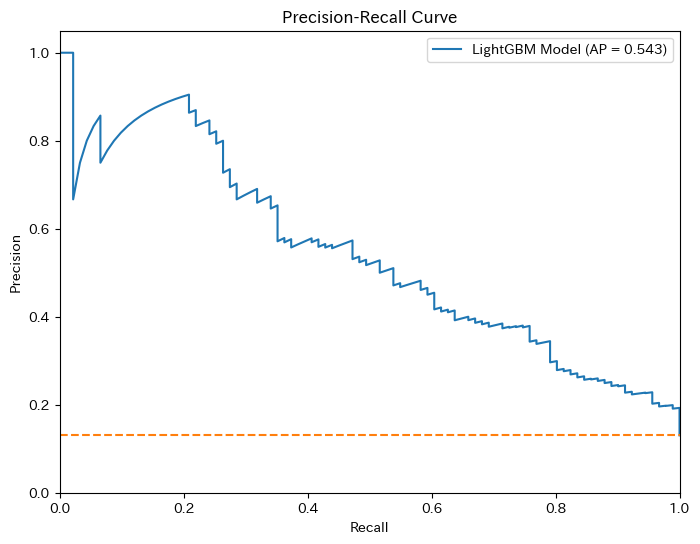

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### focal_loss, auc, pr_auc

In [ ]:
# LightGBM データセットを作成
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_columns)

# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': focal_loss_lgb,
    'metric': 'nonw',  # AUCを計算するために'metric'に'auc'を追加
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")
print(f"PR-AUCスコア: {pr_auc_score:.4f}")


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

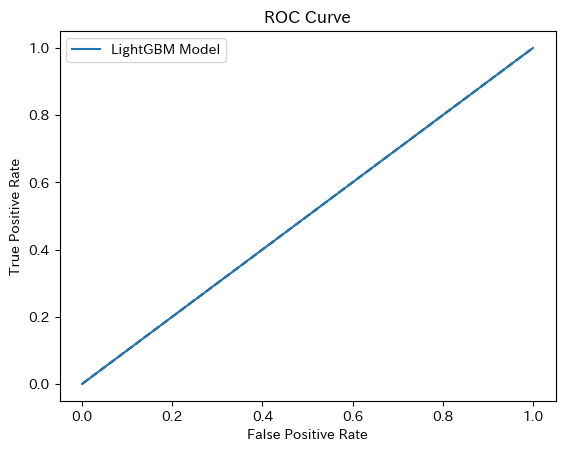

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

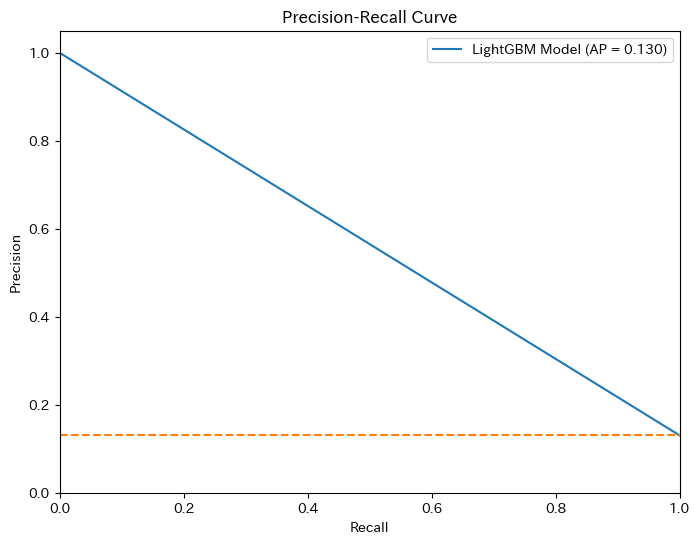

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### Weighted Cross-Entropy, auc, pr_auc

In [ ]:
# LightGBM データセットを作成
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_columns)

# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': weighted_cross_entropy(weight_positive=2.0),
    'metric': 'nonw',  # AUCを計算するために'metric'に'auc'を追加
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")
print(f"PR-AUCスコア: {pr_auc_score:.4f}")


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.883097	training's pr_auc: 0.595969	valid_1's auc: 0.828249	valid_1's pr_auc: 0.480859
[20]	training's auc: 0.898179	training's pr_auc: 0.64698	valid_1's auc: 0.831707	valid_1's pr_auc: 0.529393
[30]	training's auc: 0.916195	training's pr_auc: 0.686216	valid_1's auc: 0.849983	valid_1's pr_auc: 0.545949
[40]	training's auc: 0.928762	training's pr_auc: 0.718893	valid_1's auc: 0.853884	valid_1's pr_auc: 0.532344
[50]	training's auc: 0.941481	training's

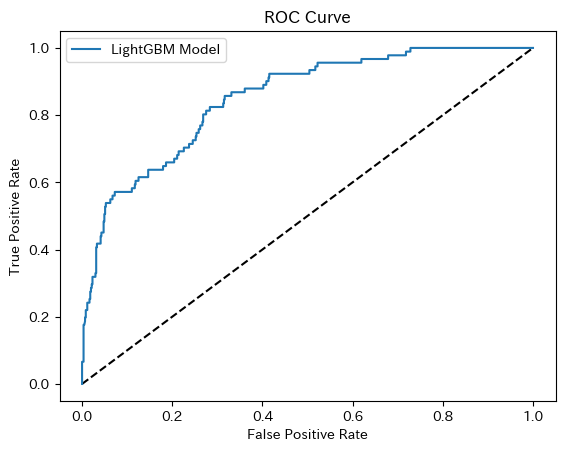

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

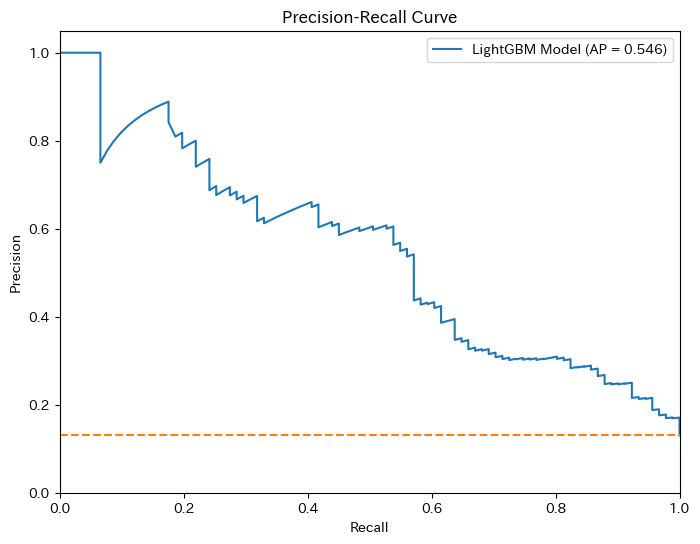

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### dice_loss, auc, pr_auc

In [ ]:
# LightGBM データセットを作成
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_columns)

# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': dice_loss(smooth=1e-6),
    'metric': 'none',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")
print(f"PR-AUCスコア: {pr_auc_score:.4f}")


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.811632	training's pr_auc: 0.51035	valid_1's auc: 0.746121	valid_1's pr_auc: 0.329627
[20]	training's auc: 0.809747	training's pr_auc: 0.509534	valid_1's auc: 0.74422	valid_1's pr_auc: 0.329316
[30]	training's auc: 0.810787	training's pr_auc: 0.52145	valid_1's auc: 0.745542	valid_1's pr_auc: 0.331727
[40]	training's auc: 0.812063	training's pr_auc: 0.526696	valid_1's auc: 0.748339	valid_1's pr_auc: 0.335819
[50]	training's auc: 0.812233	training's p

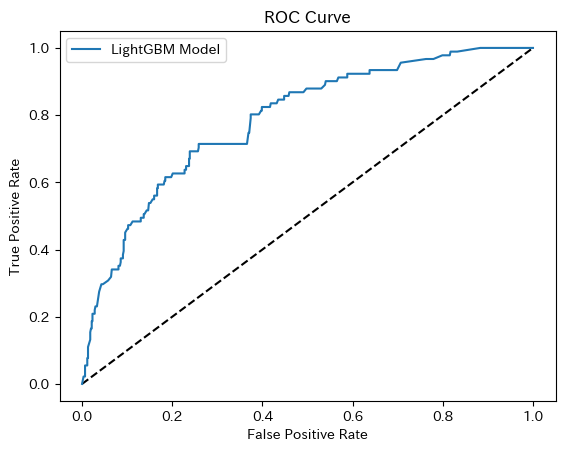

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

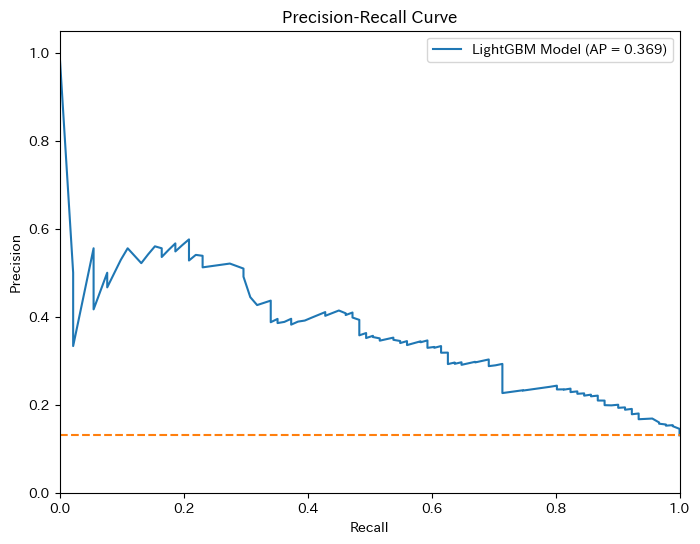

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### balanced_cross_entropy, auc, pr_auc

In [ ]:
# LightGBM データセットを作成
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_columns)

# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': balanced_cross_entropy(),
    'metric': 'none',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")
print(f"PR-AUCスコア: {pr_auc_score:.4f}")


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.895556	training's pr_auc: 0.537806	valid_1's auc: 0.839772	valid_1's pr_auc: 0.476854
[20]	training's auc: 0.911878	training's pr_auc: 0.588904	valid_1's auc: 0.854129	valid_1's pr_auc: 0.533678
[30]	training's auc: 0.928526	training's pr_auc: 0.658414	valid_1's auc: 0.858799	valid_1's pr_auc: 0.53411
[40]	training's auc: 0.941711	training's pr_auc: 0.694681	valid_1's auc: 0.859478	valid_1's pr_auc: 0.54236
[50]	training's auc: 0.950784	training's 

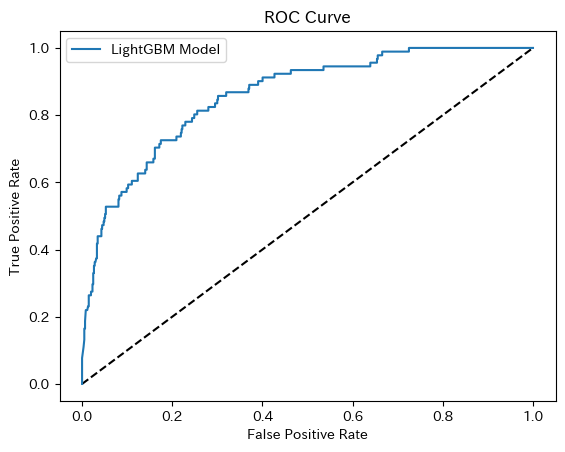

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

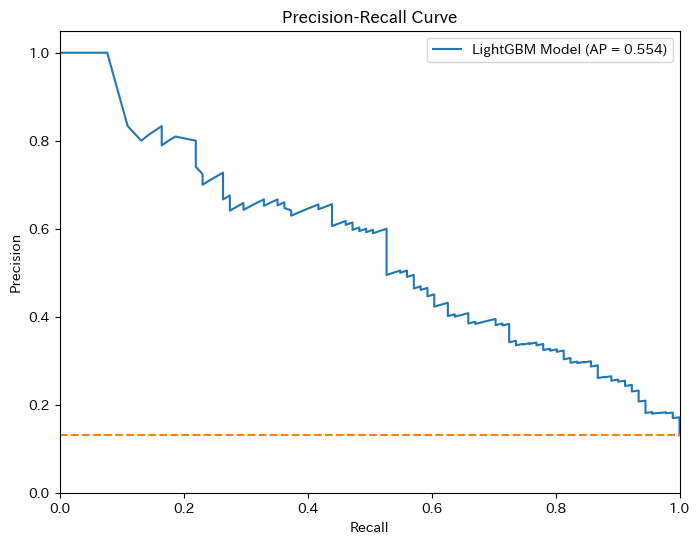

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### asymmetric_loss, auc, pr_auc

In [ ]:
# LightGBM データセットを作成
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_columns)

# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': asymmetric_loss(gamma_neg=4, gamma_pos=1),
    'metric': 'none',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")
print(f"PR-AUCスコア: {pr_auc_score:.4f}")


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.85845	training's pr_auc: 0.540624	valid_1's auc: 0.81115	valid_1's pr_auc: 0.444734
[20]	training's auc: 0.873102	training's pr_auc: 0.567153	valid_1's auc: 0.817803	valid_1's pr_auc: 0.484085
[30]	training's auc: 0.882081	training's pr_auc: 0.577432	valid_1's auc: 0.825552	valid_1's pr_auc: 0.484247
[40]	training's auc: 0.88699	training's pr_auc: 0.582278	valid_1's auc: 0.82958	valid_1's pr_auc: 0.49214
[50]	training's auc: 0.895018	training's pr_

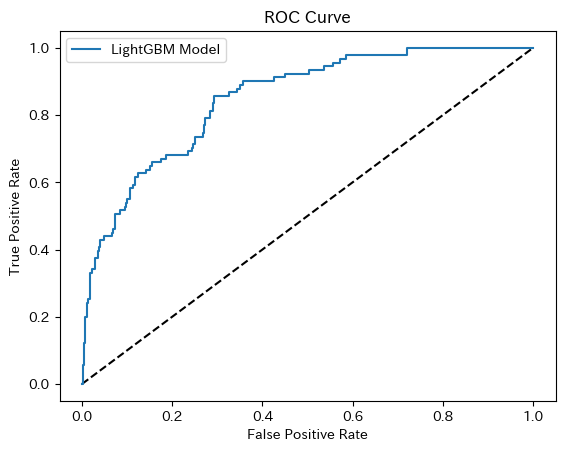

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

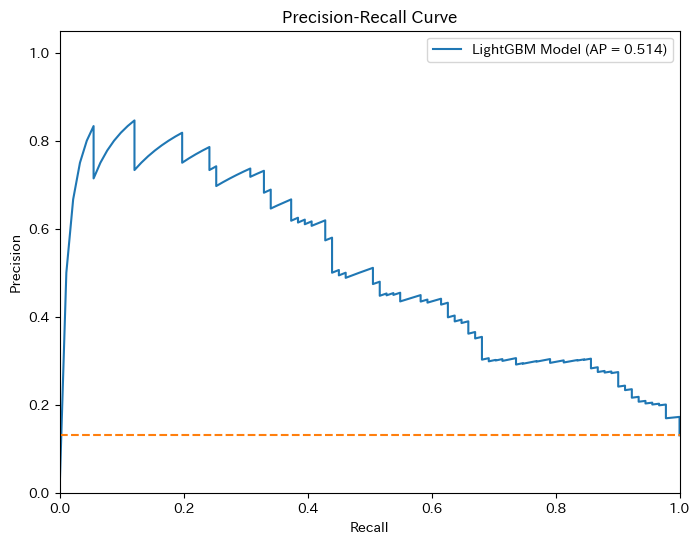

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()